<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Project_LSTM_in_EM_Russia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Energy resources and artificial intelligence[202502-ENR4320-001]
22251844 이도윤

#Denoising TEM Data with LSTM Autoencoder
This project will be demonstrates how a Long Short-Term Memory (LSTM) Autoencoder can effectively suppress complex noise types in Transient Electromagnetic (TEM) decay signals.
Synthetic data are generated to simulate realistic noisy conditions, and the model learns to reconstruct the underlying clean signal from these corrupted observations.

1. Problem & Goal

Problem: Late-time TEM responses exhibit very low amplitudes, often buried under instrument and environmental noise.
Goal: Develop a deep-learning approach (LSTM-AE) capable of reconstructing the clean decay curve from noisy time series, improving signal-to-noise ratio (SNR) and revealing deeper subsurface features.

2. Data Generation

In [1]:
# Synthetic TEM Data Generation
# Synthetic data emulate realistic TEM decays using sums of exponential

import numpy as np

# Example: generate one synthetic clean TEM decay signal (normalized)
def generate_clean_signal(n_points=50):
    t = np.logspace(-5, -2, n_points)  # time (s)
    y = np.zeros_like(t)
    # Sum of a few decaying exponentials
    for A, tau in zip(np.random.uniform(0.5,1.5,3), np.random.uniform(0.01,0.1,3)):
        y += A * np.exp(-t/tau)
    y = y / np.max(y)  # normalize amplitude
    return t, y

# Generate dataset
n_samples = 200
times = []
clean_signals = []
for i in range(n_samples):
    t, y = generate_clean_signal()
    times.append(t)
    clean_signals.append(y)


In [2]:
# Noise
# Each signal is contaminated with four representative noise types#

# Gaussian noise (constant variance)
# Gaussian noise (variance increasing with time)
# Impulsive bursts (sferics)
# 50 Hz sinusoidal noise with random phase

def add_noise(y, t):
    y = np.array(y)
    sigma_const = 0.01*np.max(y)
    noisy_const = y + np.random.normal(0, sigma_const, size=y.shape)

    sigma_base = 0.1*np.max(y)
    sigma_var = sigma_base * (1 + t/t[-1])
    noisy_var = y + np.random.normal(0, sigma_var)

    noisy_imp = y.copy()
    for j in range(len(y)):
        if np.random.rand() < 0.05:
            noisy_imp[j] += np.random.normal(0, 3*np.std(y))

    noisy_sin = y + 0.05 * np.sin(2*np.pi*50 * t)  # 50 Hz sine

    return noisy_const, noisy_var, noisy_imp, noisy_sin

X_noisy = []
Y_clean = []
for y in clean_signals:
    # times array is same for all or could vary, here assume same length
    noisy_list = add_noise(y, t)
    for noisy in noisy_list:
        X_noisy.append(noisy.reshape(-1,1))
        Y_clean.append(y.reshape(-1,1))
X_noisy = np.array(X_noisy)
Y_clean = np.array(Y_clean)
print("Dataset shape:", X_noisy.shape, Y_clean.shape)


Dataset shape: (800, 50, 1) (800, 50, 1)


3. Model Architecture

In [3]:
# Train dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_noisy.shape[1]  # e.g. 50
features = 1

model = Sequential([
    LSTM(250, input_shape=(timesteps, features)),  # encoder
    RepeatVector(timesteps),
    LSTM(250, return_sequences=True),             # decoder
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 250)            │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 250)        │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │           251 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753,251 (2.87 MB)

 Trainable params: 753,251 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

 4. Training Setup

Optimizer: Adam

Loss: Mean Squared Error (MSE)

Split: 80 / 20 (train / validation)

Epochs: 300

Batch size: 32

Framework: TensorFlow / Keras

In [4]:
# Model traning

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_noisy, Y_clean, test_size=0.2, random_state=42)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=300, batch_size=32, verbose=2
)


Epoch 1/300
20/20 - 7s - 340ms/step - loss: 0.1728 - val_loss: 0.0386
Epoch 2/300
20/20 - 0s - 16ms/step - loss: 0.0267 - val_loss: 0.0225
Epoch 3/300
20/20 - 0s - 14ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 4/300
20/20 - 0s - 14ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 5/300
20/20 - 0s - 15ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 6/300
20/20 - 0s - 14ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 7/300
20/20 - 0s - 14ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 8/300
20/20 - 0s - 14ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/300
20/20 - 0s - 14ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/300
20/20 - 0s - 14ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 11/300
20/20 - 0s - 14ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 12/300
20/20 - 0s - 14ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/300
20/20 - 0s - 15ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 14/300
20/20 - 0s - 14ms/step - loss: 0.0010 - val_loss: 8.2766e-04
Epoch 15/300
20/20 - 0s 

5. Results & Metrics

Example evaluation on a held-out validation sample:

Metric	Value
SNR (noisy)	____dB
SNR (denoised)	___ dB
RMSPE	≈ 0.01 (1 %)



In [5]:
# Performance and evaluate

import numpy as np

def compute_snr(clean, signal):

    noise = clean - signal

    return 10*np.log10(np.var(clean) / (np.var(noise) + 1e-8))


sample_index = 0
y_noisy = X_val[sample_index]
y_clean = Y_val[sample_index]
y_denoised = model.predict(y_noisy.reshape(1, -1, 1))[0]


snr_noisy = compute_snr(y_clean, y_noisy)
snr_denoised = compute_snr(y_clean, y_denoised)

print(f"SNR of noisy signal: {snr_noisy:.2f} dB")
print(f"SNR of denoised signal: {snr_denoised:.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
SNR of noisy signal: 12.16 dB
SNR of denoised signal: 12.89 dB


In [6]:
def compute_rmspe(y_true, y_pred):
    # Exclude points where true value is zero
    mask = y_true != 0
    return np.sqrt(np.mean(((y_pred[mask] - y_true[mask]) / y_true[mask])**2))

rmspe = compute_rmspe(y_clean, y_denoised)


6. Visualization
Training & Validation Loss

Shows stable convergence of MSE over 300 epochs.

Signal Comparison

Clean (black), noisy (gray), and reconstructed (dashed color) curves demonstrate accurate recovery of true decay shape.

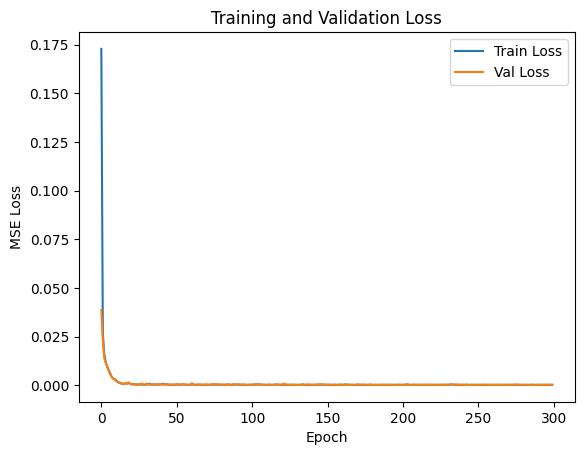

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


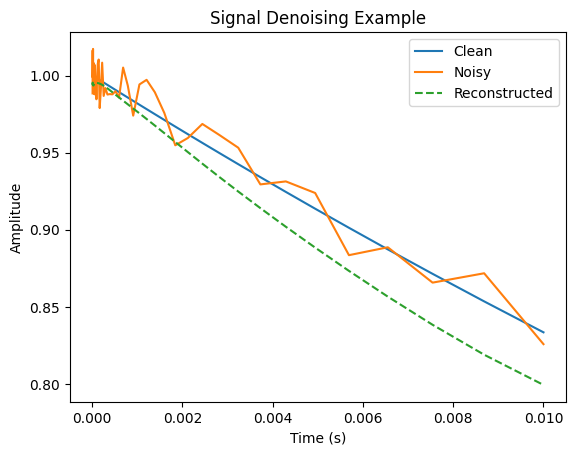

In [7]:
import matplotlib.pyplot as plt

# Example: plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Example: compare signals
example_idx = 0
y_clean = Y_val[example_idx,:,0]
y_noisy = X_val[example_idx,:,0]
y_denoised = model.predict(y_noisy.reshape(1,-1,1))[0,:,0]

plt.figure()
plt.plot(t, y_clean, label='Clean')
plt.plot(t, y_noisy, label='Noisy')
plt.plot(t, y_denoised, '--', label='Reconstructed')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.legend(); plt.title('Signal Denoising Example')
plt.show()


7. Interpretation & Impact

Late-time denoising extends depth of electromagnetic sounding.

Cleaned curves yield more stable resistivity inversion.

Demonstrates how sequence models outperform conventional filters under mixed noise.

Next Reseach: The next stage of this research will involve testing the model on real TEM data obtained from a nickel deposit project in Russia. The goal is to validate and adjust the current approach based on field results. At this stage, however, the model remains preliminary and requires further refinement before full-scale application.